In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import tensorflow as tf
import tensorflow_addons as tfa

import sklearn
from sklearn import model_selection
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

from tqdm import tqdm
import random
from random import choices

from collections import Counter, defaultdict

import warnings
warnings.filterwarnings("ignore")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# tf setup
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

MIXED_PRECISION = False
XLA_ACCELERATE = True

if MIXED_PRECISION:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    if tpu: policy = tf.keras.mixed_precision.experimental.Policy('mixed_bfloat16')
    else: policy = tf.keras.mixed_precision.experimental.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
    print('Mixed precision enabled')

if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
    print('Accelerated Linear Algebra enabled')

Tensorflow version 2.3.1
Accelerated Linear Algebra enabled


# Config

In [3]:
CV_STRATEGY = 'StratifiedGroupKFold' # 'StratifiedGroupKFold' # GroupKFold, PurgedGroupTimeSeriesSplit
SEED = 2021
START_DATE = 86
FOLDS = 5
DEBUG = False

# CV Strategy

## PurgedGroupTimeSeriesSplit
Click the code button to see. 

In [4]:
# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

## GroupKFold, StratifiedGroupKFold

In [5]:
# ---- GroupKFold ----
class GroupKFold(object):
    """
    GroupKFold with random shuffle with a sklearn-like structure
    """

    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X, y, group):
        kf = model_selection.KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        unique_ids = X[group].unique()
        for fold, (tr_group_idx, va_group_idx) in enumerate(kf.split(unique_ids)):
            # split group
            tr_group, va_group = unique_ids[tr_group_idx], unique_ids[va_group_idx]
            train_idx = np.where(X[group].isin(tr_group))[0]
            val_idx = np.where(X[group].isin(va_group))[0]
            yield train_idx, val_idx

# ---- StratifiedGroupKFold ----
class StratifiedGroupKFold(object):
    """
    StratifiedGroupKFold with random shuffle with a sklearn-like structure
    """

    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X, y, group):
        labels_num = np.max(y) + 1
        y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
        y_distr = Counter()
        groups = X[group].values
        for label, g in zip(y, groups):
            y_counts_per_group[g][label] += 1
            y_distr[label] += 1

        y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
        groups_per_fold = defaultdict(set)

        def eval_y_counts_per_fold(y_counts, fold):
            y_counts_per_fold[fold] += y_counts
            std_per_label = []
            for label in range(labels_num):
                label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(self.n_splits)])
                std_per_label.append(label_std)
            y_counts_per_fold[fold] -= y_counts
            return np.mean(std_per_label)
        
        groups_and_y_counts = list(y_counts_per_group.items())
        random.Random(self.random_state).shuffle(groups_and_y_counts)

        for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
            best_fold = None
            min_eval = None
            for i in range(self.n_splits):
                fold_eval = eval_y_counts_per_fold(y_counts, i)
                if min_eval is None or fold_eval < min_eval:
                    min_eval = fold_eval
                    best_fold = i
            y_counts_per_fold[best_fold] += y_counts
            groups_per_fold[best_fold].add(g)

        all_groups = set(groups)
        for i in range(self.n_splits):
            train_groups = all_groups - groups_per_fold[i]
            test_groups = groups_per_fold[i]

            train_idx = [i for i, g in enumerate(groups) if g in train_groups]
            test_idx = [i for i, g in enumerate(groups) if g in test_groups]

            yield train_idx, test_idx

### Loading the training data

In [6]:
train = pd.read_feather('../input/jane-street-save-as-feather/train.feather') # faster data load
train = train.query(f'date >= {START_DATE}').reset_index(drop = True) 
train = train.astype({c: np.float32 for c in train.select_dtypes(include='float64').columns}) #limit memory use
train.fillna(train.mean(),inplace=True)
train = train.query('weight > 0').reset_index(drop = True)
#train = train.query('weight != 0').reset_index(drop = True)
#train['action'] = (train['resp'] > 0).astype('int')
train['action'] =  (  (train['resp_1'] > 0 ) & (train['resp_2'] > 0 ) & (train['resp_3'] > 0 ) & (train['resp_4'] > 0 ) &  (train['resp'] > 0 )   ).astype('int')
features = [c for c in train.columns if 'feature' in c]
resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']

In [7]:
if DEBUG:
    train = train.sample(10000, random_state=SEED)

X = train[features].values
y = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T #Multitarget

f_mean = np.mean(train[features[1:]].values,axis=0)

### Creating Autoencoder

In [8]:
def create_autoencoder(input_dim,output_dim,noise=0.05):
    i = tf.keras.layers.Input(input_dim)
    encoded = tf.keras.layers.BatchNormalization()(i)
    encoded = tf.keras.layers.GaussianNoise(noise)(encoded)
    encoded = tf.keras.layers.Dense(64,activation='relu')(encoded)
    decoded = tf.keras.layers.Dropout(0.2)(encoded)
    decoded = tf.keras.layers.Dense(input_dim,name='decoded')(decoded)
    x = tf.keras.layers.Dense(32,activation='relu')(decoded)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(output_dim,activation='sigmoid',name='label_output')(x)
    
    encoder = tf.keras.models.Model(inputs=i,outputs=encoded)
    autoencoder = tf.keras.models.Model(inputs=i,outputs=[decoded,x])
    
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001), 
                        loss={'decoded':'mse','label_output':'binary_crossentropy'})
    return autoencoder, encoder

In [9]:
def create_resnet(n_features, n_labels, encoder, label_smoothing = 0.0005):    
    input_1 = tf.keras.layers.Input(shape = (n_features,))
    input_2 = encoder(input_1)

    head_1 = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, activation="elu"), 
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation = "elu")
        ],name='Head1') 

    input_3 = head_1(input_1)
    input_3_concat = tf.keras.layers.Concatenate()([input_2, input_3])

    head_2 = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(512, "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, "elu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, "relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, "elu")
        ],name='Head2')

    input_4 = head_2(input_3_concat)
    input_4_avg = tf.keras.layers.Average()([input_3, input_4]) 

    head_3 = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1), name='l2_norm'),
        tf.keras.layers.Dense(n_labels, activation="sigmoid")
        ],name='Head3')

    output = head_3(input_4_avg)

    model = tf.keras.models.Model(inputs = [input_1, ], outputs = output)
    opt = tfa.optimizers.RectifiedAdam(learning_rate=1e-03)
    opt = tfa.optimizers.SWA(opt)
    model.compile(optimizer=opt, 
                  loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing), 
                  metrics=['AUC'])
    
    return model

In [10]:
autoencoder, encoder = create_autoencoder(X.shape[-1],y.shape[-1],noise=0.1)
autoencoder.fit(X,(X,y),
                epochs=1000,
                batch_size=2048, 
                validation_split=0.1,
                callbacks=[tf.keras.callbacks.EarlyStopping('val_loss',patience=10,restore_best_weights=True)])
encoder.save_weights('./encoder.hdf5')
encoder.trainable = False

Epoch 1/1000
691/691 [==============================] - 6s 9ms/step - loss: 2.3766 - decoded_loss: 1.6684 - label_output_loss: 0.7082 - val_loss: 1.2757 - val_decoded_loss: 0.5855 - val_label_output_loss: 0.6902
Epoch 2/1000
691/691 [==============================] - 7s 10ms/step - loss: 1.8116 - decoded_loss: 1.1200 - label_output_loss: 0.6916 - val_loss: 1.1763 - val_decoded_loss: 0.4865 - val_label_output_loss: 0.6897
Epoch 3/1000
691/691 [==============================] - 4s 6ms/step - loss: 1.7645 - decoded_loss: 1.0735 - label_output_loss: 0.6910 - val_loss: 1.1288 - val_decoded_loss: 0.4394 - val_label_output_loss: 0.6895
Epoch 4/1000
691/691 [==============================] - 4s 6ms/step - loss: 1.7415 - decoded_loss: 1.0507 - label_output_loss: 0.6908 - val_loss: 1.1068 - val_decoded_loss: 0.4175 - val_label_output_loss: 0.6893
Epoch 5/1000
691/691 [==============================] - 4s 6ms/step - loss: 1.7252 - decoded_loss: 1.0346 - label_output_loss: 0.6906 - val_loss: 1.097

In [11]:
model = create_resnet(130, 5, encoder)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 130)]        0                                            
__________________________________________________________________________________________________
Head1 (Sequential)              (None, 256)          200968      input_2[0][0]                    
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 64)           8904        input_2[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 320)          0           functional_1[0][0]               
                                                                 Head1[0][0]           

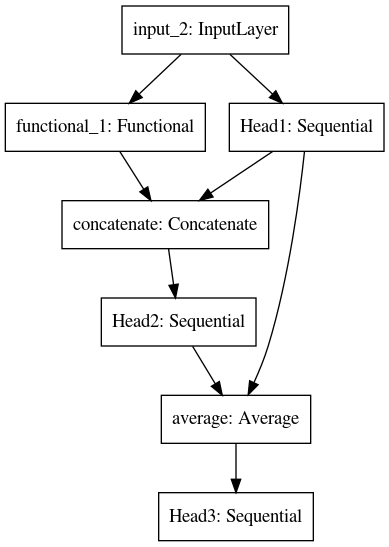

In [12]:
tf.keras.utils.plot_model(model)

In [13]:
%%time


if CV_STRATEGY == 'PurgedGroupTimeSeriesSplit':
    gkf = PurgedGroupTimeSeriesSplit(n_splits=FOLDS, group_gap=20)
    splits = list(gkf.split(y, groups=train['date'].values))    
    
elif CV_STRATEGY == "GroupKFold":
    cv = GroupKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    splits = cv.split(train, train['resp'].values.astype(int), 'date')

elif CV_STRATEGY ==  "StratifiedGroupKFold":
    cv = StratifiedGroupKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
    splits = cv.split(train, train['resp'].values.astype(int), 'date')

models = []
for fold, (train_indices, test_indices) in tqdm(enumerate(splits)):
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    # model
    tf.keras.backend.clear_session()
    model = create_resnet(X.shape[-1], y.shape[-1], encoder)
    
    # callbacks
    er = tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss')
    ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=8, verbose=1, mode='min')
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'./model_{SEED}_{fold}.hdf5', save_weights_only=True, verbose=0, monitor='val_loss', save_best_only=True)
    nn_callbacks = [er, ReduceLR, model_checkpoint_callback]
    
    # fit
    model.fit(X_train, y_train, validation_data=(X_test,y_test), 
              epochs=192, batch_size=2048, callbacks=nn_callbacks)
    models.append(model)

0it [00:00, ?it/s]

Epoch 1/192
615/615 [==============================] - 18s 30ms/step - loss: 0.6911 - auc: 0.5344 - val_loss: 0.6904 - val_auc: 0.5407
Epoch 2/192
615/615 [==============================] - 20s 33ms/step - loss: 0.6894 - auc: 0.5453 - val_loss: 0.6889 - val_auc: 0.5465
Epoch 3/192
615/615 [==============================] - 15s 24ms/step - loss: 0.6887 - auc: 0.5491 - val_loss: 0.6889 - val_auc: 0.5472
Epoch 4/192
615/615 [==============================] - 14s 23ms/step - loss: 0.6881 - auc: 0.5517 - val_loss: 0.6889 - val_auc: 0.5476
Epoch 5/192
615/615 [==============================] - 16s 26ms/step - loss: 0.6877 - auc: 0.5539 - val_loss: 0.6890 - val_auc: 0.5491
Epoch 6/192
615/615 [==============================] - 14s 23ms/step - loss: 0.6871 - auc: 0.5565 - val_loss: 0.6888 - val_auc: 0.5496
Epoch 7/192
615/615 [==============================] - 15s 25ms/step - loss: 0.6865 - auc: 0.5590 - val_loss: 0.6886 - val_auc: 0.5502
Epoch 8/192
615/615 [==============================] - 

1it [04:24, 264.65s/it]

Epoch 1/192
614/614 [==============================] - 18s 30ms/step - loss: 0.6910 - auc: 0.5346 - val_loss: 0.6901 - val_auc: 0.5424
Epoch 2/192
614/614 [==============================] - 20s 32ms/step - loss: 0.6893 - auc: 0.5459 - val_loss: 0.6899 - val_auc: 0.5420
Epoch 3/192
614/614 [==============================] - 17s 28ms/step - loss: 0.6886 - auc: 0.5495 - val_loss: 0.6893 - val_auc: 0.5457
Epoch 4/192
614/614 [==============================] - 14s 23ms/step - loss: 0.6881 - auc: 0.5522 - val_loss: 0.6896 - val_auc: 0.5446
Epoch 5/192
614/614 [==============================] - 16s 26ms/step - loss: 0.6875 - auc: 0.5549 - val_loss: 0.6901 - val_auc: 0.5441
Epoch 6/192
614/614 [==============================] - 15s 25ms/step - loss: 0.6870 - auc: 0.5572 - val_loss: 0.6900 - val_auc: 0.5457
Epoch 7/192
614/614 [==============================] - 14s 23ms/step - loss: 0.6865 - auc: 0.5593 - val_loss: 0.6898 - val_auc: 0.5474
Epoch 8/192
614/614 [==============================] - 

2it [07:48, 246.39s/it]

Epoch 1/192
614/614 [==============================] - 19s 31ms/step - loss: 0.6911 - auc: 0.5342 - val_loss: 0.6894 - val_auc: 0.5463
Epoch 2/192
614/614 [==============================] - 21s 34ms/step - loss: 0.6894 - auc: 0.5451 - val_loss: 0.6893 - val_auc: 0.5476
Epoch 3/192
614/614 [==============================] - 16s 26ms/step - loss: 0.6886 - auc: 0.5493 - val_loss: 0.6902 - val_auc: 0.5436
Epoch 4/192
614/614 [==============================] - 15s 24ms/step - loss: 0.6880 - auc: 0.5521 - val_loss: 0.6888 - val_auc: 0.5487
Epoch 5/192
614/614 [==============================] - 17s 28ms/step - loss: 0.6874 - auc: 0.5547 - val_loss: 0.6897 - val_auc: 0.5458
Epoch 6/192
614/614 [==============================] - 15s 24ms/step - loss: 0.6869 - auc: 0.5569 - val_loss: 0.6897 - val_auc: 0.5472
Epoch 7/192
614/614 [==============================] - 18s 29ms/step - loss: 0.6862 - auc: 0.5599 - val_loss: 0.6904 - val_auc: 0.5473
Epoch 8/192
614/614 [==============================] - 

3it [11:28, 238.43s/it]

Epoch 1/192
615/615 [==============================] - 20s 32ms/step - loss: 0.6910 - auc: 0.5348 - val_loss: 0.6897 - val_auc: 0.5447
Epoch 2/192
615/615 [==============================] - 21s 34ms/step - loss: 0.6893 - auc: 0.5462 - val_loss: 0.6891 - val_auc: 0.5457
Epoch 3/192
615/615 [==============================] - 14s 23ms/step - loss: 0.6885 - auc: 0.5501 - val_loss: 0.6890 - val_auc: 0.5469
Epoch 4/192
615/615 [==============================] - 15s 25ms/step - loss: 0.6879 - auc: 0.5534 - val_loss: 0.6894 - val_auc: 0.5467
Epoch 5/192
615/615 [==============================] - 17s 28ms/step - loss: 0.6874 - auc: 0.5555 - val_loss: 0.6896 - val_auc: 0.5426
Epoch 6/192
615/615 [==============================] - 15s 24ms/step - loss: 0.6868 - auc: 0.5579 - val_loss: 0.6892 - val_auc: 0.5467
Epoch 7/192
615/615 [==============================] - 15s 24ms/step - loss: 0.6862 - auc: 0.5603 - val_loss: 0.6899 - val_auc: 0.5464
Epoch 8/192
615/615 [==============================] - 

4it [14:50, 227.49s/it]

Epoch 1/192
614/614 [==============================] - 21s 34ms/step - loss: 0.6909 - auc: 0.5353 - val_loss: 0.6904 - val_auc: 0.5407
Epoch 2/192
614/614 [==============================] - 21s 34ms/step - loss: 0.6891 - auc: 0.5466 - val_loss: 0.6898 - val_auc: 0.5437
Epoch 3/192
614/614 [==============================] - 14s 23ms/step - loss: 0.6884 - auc: 0.5502 - val_loss: 0.6897 - val_auc: 0.5440
Epoch 4/192
614/614 [==============================] - 15s 25ms/step - loss: 0.6879 - auc: 0.5530 - val_loss: 0.6902 - val_auc: 0.5439
Epoch 5/192
614/614 [==============================] - 19s 31ms/step - loss: 0.6873 - auc: 0.5556 - val_loss: 0.6894 - val_auc: 0.5466
Epoch 6/192
614/614 [==============================] - 15s 24ms/step - loss: 0.6867 - auc: 0.5580 - val_loss: 0.6900 - val_auc: 0.5451
Epoch 7/192
614/614 [==============================] - 14s 23ms/step - loss: 0.6861 - auc: 0.5602 - val_loss: 0.6896 - val_auc: 0.5478
Epoch 8/192
614/614 [==============================] - 

5it [18:43, 224.73s/it]

CPU times: user 21min 5s, sys: 1min 41s, total: 22min 46s
Wall time: 18min 43s


In [14]:
"""f = np.median
th = 0.500

import janestreet
env = janestreet.make_env()
for (test_df, pred_df) in tqdm(env.iter_test()):
    if test_df['weight'].item() > 0:
        x_tt = test_df.loc[:, features].values
        
        # GBDT inference with treelite
        batch = treelite_runtime.Batch.from_npy2d(x_tt)
        xgb_pred = predictor.predict(batch)
    
        # NN inference
        if np.isnan(x_tt[:, 1:].sum()):
            x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean
        
        pred = np.mean([model(x_tt, training = False).numpy() for model in models],axis=0)
        pred = f(pred)
        
        # ensemble
        pred_df.action = np.where(0.9*pred + 0.1*xgb_pred >= th, 1, 0).astype(int)
    else:
        pred_df.action = 0
    env.predict(pred_df)"""

"f = np.median\nth = 0.500\n\nimport janestreet\nenv = janestreet.make_env()\nfor (test_df, pred_df) in tqdm(env.iter_test()):\n    if test_df['weight'].item() > 0:\n        x_tt = test_df.loc[:, features].values\n        \n        # GBDT inference with treelite\n        batch = treelite_runtime.Batch.from_npy2d(x_tt)\n        xgb_pred = predictor.predict(batch)\n    \n        # NN inference\n        if np.isnan(x_tt[:, 1:].sum()):\n            x_tt[:, 1:] = np.nan_to_num(x_tt[:, 1:]) + np.isnan(x_tt[:, 1:]) * f_mean\n        \n        pred = np.mean([model(x_tt, training = False).numpy() for model in models],axis=0)\n        pred = f(pred)\n        \n        # ensemble\n        pred_df.action = np.where(0.9*pred + 0.1*xgb_pred >= th, 1, 0).astype(int)\n    else:\n        pred_df.action = 0\n    env.predict(pred_df)"